2025-05-06 05:01:29.272076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 05:01:29.292587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 05:01:29.292604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 05:01:29.293390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 05:01:29.297113: I tensorflow/core/platform/cpu_feature_guar

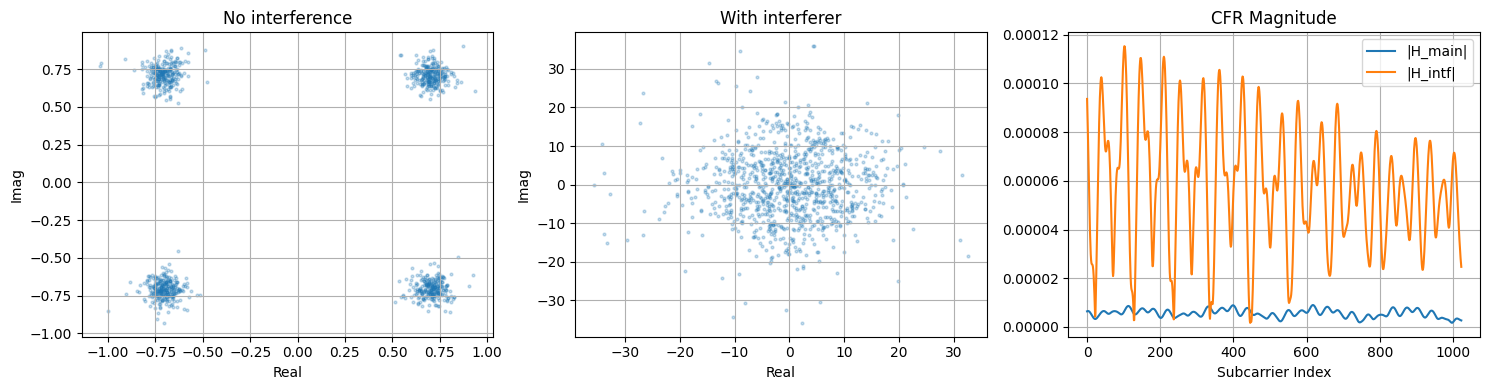

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sionna
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, PathSolver, subcarrier_frequencies

# GPU setup
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Parameters
SCENE_NAME = "GIS.xml"
TX_ARRAY_CONFIG = {"num_rows": 1, "num_cols": 1, "vertical_spacing": 0.5, "horizontal_spacing": 0.5, "pattern": "iso", "polarization": "V"}
RX_ARRAY_CONFIG = TX_ARRAY_CONFIG
TX_LIST = [
    ("tx0", [-100, -100, 20], [np.pi*5/6, 0, 0], "desired", 30),
    ("tx1", [-100, 50, 20], [np.pi/6, 0, 0], "desired", 30),
    ("tx2", [100, -100, 20], [-np.pi/2, 0, 0], "desired", 30),
    ("jam1", [100, 50, 20], [np.pi/2, 0, 0], "jammer", 40),
    ("jam2", [50, 50, 20], [np.pi/2, 0, 0], "jammer", 40),
    ("jam3", [-50, -50, 20], [np.pi/2, 0, 0], "jammer", 40),
]
RX_CONFIG = ("rx", [0, 0, 20])
PATHSOLVER_ARGS = {"max_depth": 10, "los": True, "specular_reflection": True, "diffuse_reflection": False, "refraction": False, "synthetic_array": False, "seed": 41}
N_SYMBOLS = 1
N_SUBCARRIERS = 1024
SUBCARRIER_SPACING = 30e3
EBN0_dB = 20.0

# Scene setup
scene = load_scene(SCENE_NAME)
scene.tx_array = PlanarArray(**TX_ARRAY_CONFIG)
scene.rx_array = PlanarArray(**RX_ARRAY_CONFIG)

# Clear existing transmitters and receivers
for name in list(scene.transmitters.keys()) + list(scene.receivers.keys()):
    scene.remove(name)

# Add transmitters
def add_tx(scene, name, pos, ori, role, power_dbm):
    tx = Transmitter(name=name, position=pos, orientation=ori, power_dbm=power_dbm)
    tx.role = role
    scene.add(tx)
    return tx

for name, pos, ori, role, p_dbm in TX_LIST:
    add_tx(scene, name, pos, ori, role, p_dbm)

# Add receiver
rx_name, rx_pos = RX_CONFIG
scene.add(Receiver(name=rx_name, position=rx_pos))

# Group transmitters
tx_names = list(scene.transmitters.keys())
all_txs = [scene.get(n) for n in tx_names]
idx_des = [i for i, tx in enumerate(all_txs) if tx.role == "desired"]
idx_jam = [i for i, tx in enumerate(all_txs) if tx.role == "jammer"]

# Compute CFR
freqs = subcarrier_frequencies(N_SUBCARRIERS, SUBCARRIER_SPACING)
for name in tx_names:
    scene.get(name).velocity = [30, 0, 0]
paths = PathSolver()(scene, **PATHSOLVER_ARGS)

def dbm2w(dbm):
    return 10**(dbm/10) / 1000

tx_powers = [dbm2w(scene.get(n).power_dbm) for n in tx_names]
ofdm_symbol_duration = 1 / SUBCARRIER_SPACING
H_unit = paths.cfr(
    frequencies=freqs,
    sampling_frequency=1/ofdm_symbol_duration,
    num_time_steps=N_SUBCARRIERS,
    normalize_delays=True,
    normalize=False,
    out_type="numpy"
).squeeze()  # shape: (num_tx, T, F)

H_all = np.sqrt(np.array(tx_powers)[:, None, None]) * H_unit
H = H_unit[:, 0, :]  # Take first time step
h_main = sum(np.sqrt(tx_powers[i]) * H[i] for i in idx_des)
h_intf = sum(np.sqrt(tx_powers[i]) * H[i] for i in idx_jam)

# Generate QPSK+OFDM symbols
bits = np.random.randint(0, 2, (N_SYMBOLS, N_SUBCARRIERS, 2))
bits_jam = np.random.randint(0, 2, (N_SYMBOLS, N_SUBCARRIERS, 2))
X_sig = (1 - 2 * bits[..., 0] + 1j * (1 - 2 * bits[..., 1])) / np.sqrt(2)
X_jam = (1 - 2 * bits_jam[..., 0] + 1j * (1 - 2 * bits_jam[..., 1])) / np.sqrt(2)

Y_sig = X_sig * h_main[None, :]
Y_int = X_jam * h_intf[None, :]
p_sig = np.mean(np.abs(Y_sig)**2)
N0 = p_sig / (10**(EBN0_dB/10) * 2)
noise = np.sqrt(N0/2) * (np.random.randn(*Y_sig.shape) + 1j * np.random.randn(*Y_sig.shape))
Y_tot = Y_sig + Y_int + noise
y_eq_no_i = (Y_sig + noise) / h_main
y_eq_with_i = Y_tot / h_main

# Plot constellation and CFR
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(y_eq_no_i.real, y_eq_no_i.imag, s=4, alpha=0.25)
ax[0].set(title="No interference", xlabel="Real", ylabel="Imag")
ax[0].grid(True)
ax[1].scatter(y_eq_with_i.real, y_eq_with_i.imag, s=4, alpha=0.25)
ax[1].set(title="With interferer", xlabel="Real", ylabel="Imag")
ax[1].grid(True)
ax[2].plot(np.abs(h_main), label="|H_main|")
ax[2].plot(np.abs(h_intf), label="|H_intf|")
ax[2].set(title="CFR Magnitude", xlabel="Subcarrier Index")
ax[2].legend()
ax[2].grid(True)
plt.tight_layout()
plt.show()